# Imports

In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt
# from dataset import CamSegDataset
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
import random
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import albumentations as A

# Directories

In [26]:
DATA_DIR = './data/CamVid/'
EXPANDED_DATA_DIR = "./data/CamVidExpanded/"

In [27]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [28]:
expanded_x_train_dir = os.path.join(EXPANDED_DATA_DIR, 'train')
expanded_y_train_dir = os.path.join(EXPANDED_DATA_DIR, 'trainannot')

expanded_x_valid_dir = os.path.join(EXPANDED_DATA_DIR, 'val')
expanded_y_valid_dir = os.path.join(EXPANDED_DATA_DIR, 'valannot')

expanded_x_test_dir = os.path.join(EXPANDED_DATA_DIR, 'test')
expanded_y_test_dir = os.path.join(EXPANDED_DATA_DIR, 'testannot')

# Dataset Class

In [29]:
class CamSegDataset(Dataset):
    """
    PyTorch CamSeg Dataset for loading and transforming images and masks for segmentation tasks.

    Args:
        images_dir (str): Path to the images folder.
        masks_dir (str): Path to the segmentation masks folder.
        classes (list): Class names to extract from segmentation mask.
        augmentation (albumentations.Compose): Data transformation pipeline (e.g., flip, scale).
        preprocessing (albumentations.Compose): Data preprocessing (e.g., normalization).
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    # def __init__(self, images_dir, masks_dir, new_images_dir, new_masks_dir, classes=None, augmentation=None, preprocessing=None):
    #     self.images_fps = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir)])
    #     self.masks_fps = sorted([os.path.join(masks_dir, img) for img in os.listdir(masks_dir)])
    #     self.new_images_fps = sorted([os.path.join(new_images_dir, img) for img in os.listdir(new_images_dir)])
    #     self.new_masks_fps = sorted([os.path.join(new_masks_dir, img) for img in os.listdir(new_masks_dir)])
    #     self.images_fps.extend(self.new_images_fps)
    #     self.masks_fps.extend(self.new_masks_fps)
    #     # Convert class names to class indices
    #     self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
    #     self.augmentation = augmentation
    #     self.preprocessing = preprocessing

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.images_fps = sorted([os.path.join(images_dir, img) for img in os.listdir(images_dir)])
        self.masks_fps = sorted([os.path.join(masks_dir, img) for img in os.listdir(masks_dir)])
        # Convert class names to class indices
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Load image and mask
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # Extract specific classes from mask
        masks = [(mask == v).astype('float32') for v in self.class_values]
        mask = np.stack(masks, axis=-1)
        
        # Add background if the mask is not binary
        # if mask.shape[-1] != 1:
        #     background = 1 - mask.sum(axis=-1, keepdims=True)
        #     mask = np.concatenate((mask, background), axis=-1)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Apply preprocessing
        if self.preprocessing:
            processed = self.preprocessing(image=image, mask=mask)
            image, mask = processed['image'], processed['mask']

        # Convert to torch tensors
        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask).permute(2, 0, 1)  # Move channels to first dimension
        return image, mask

    def __len__(self):
        return len(self.images_fps)

# Visualisation functions

In [37]:
# Helper function for data visualization with debugging
def visualize(**images):
    """Plot images in one row with color for each class mask."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())

        # Ensure the image has the correct format for imshow
        if isinstance(image, torch.Tensor):
            image = image.numpy()  # Convert tensor to numpy array if needed

        # Transpose if the image is in (channels, height, width) format
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        # Print shape for debugging
        # print(f"{name} - shape: {image.shape}")
        print(f"{name}: {image}")
        
        # Display with a color map for masks
        plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.show()
    
def colorize_mask(mask, color):
    """Apply a color to a single-channel mask."""
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Create a 3-channel image
    for c in range(3):  # Apply the color
        colored_mask[..., c] = mask * color[c]
    return colored_mask

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Augmentation

In [31]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=(0, 0, 0)),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.2, p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         A.PadIfNeeded(384, 480)
#     ]
#     return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

# Visualisation Test

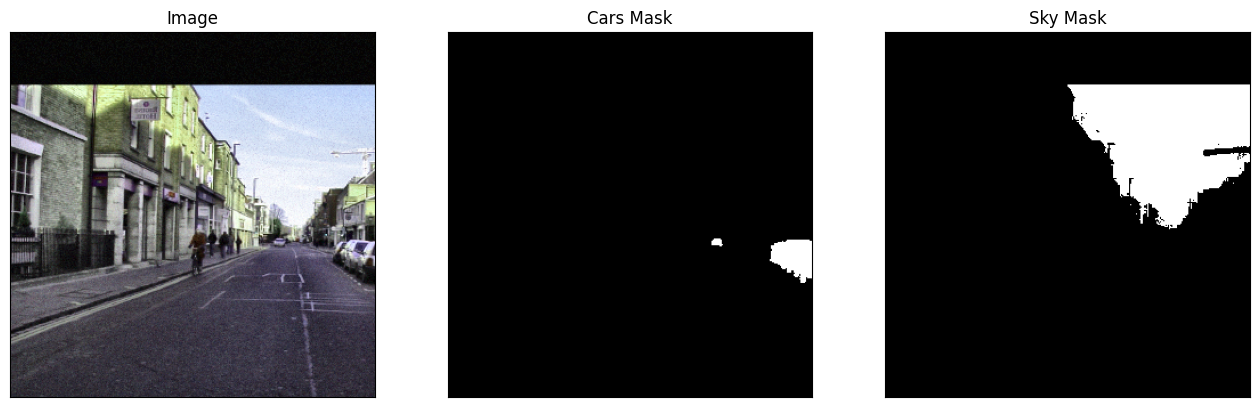

In [32]:
# Lets look at augmented data we have
dataset = CamSegDataset(x_train_dir, y_train_dir, classes=['car', 'sky'], augmentation=get_training_augmentation())

# Get a random sample
random_index = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_index]  # Use the random index to get a sample

visualize(
    image=image, 
    cars_mask=mask[0].squeeze(),
    sky_mask=mask[1].squeeze(),
    # background_mask=mask[2].squeeze(),
)

# Model

In [33]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

# Train

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

LEARNING_RATE = 3e-4
BATCH_SIZE = 8

# CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
#             'tree', 'signsymbol', 'fence', 'car', 
#             'pedestrian', 'bicyclist', 'unlabelled']
CLASSES = ['car', 'sky']

COLORS = {
    'car': (255, 0, 0),  # Red for 'car'
    'sky': (0, 0, 255)   # Blue for 'sky'
}

train_dataset = CamSegDataset(x_train_dir, y_train_dir, classes=CLASSES, augmentation=get_training_augmentation())
val_dataset = CamSegDataset(x_valid_dir, y_valid_dir, classes=CLASSES, augmentation=get_training_augmentation())
test_dataset = CamSegDataset(x_test_dir, y_test_dir, classes=CLASSES, augmentation=get_training_augmentation())

# train_dataset = CamSegDataset(expanded_x_train_dir, expanded_y_train_dir, classes=CLASSES)
# val_dataset = CamSegDataset(expanded_x_valid_dir, expanded_y_valid_dir, classes=CLASSES)
# test_dataset = CamSegDataset(expanded_x_test_dir, expanded_y_test_dir, classes=CLASSES)

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=len(CLASSES)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
EPOCHS = 30
# Calculate the interval to print the loss
print_interval = max(1, EPOCHS // 5)

# Initialize TensorBoard writer
writer = SummaryWriter()

train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=False)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)

        optimizer.zero_grad()
        
        # Calculate loss
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            
            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    
    # Log the training and validation loss to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch + 1)
    writer.add_scalar("Loss/Validation", val_loss, epoch + 1)

    # Print losses only at specified intervals
    if (epoch + 1) % print_interval == 0 or epoch == EPOCHS - 1:
        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print("-" * 30)

# Generate current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model with timestamp as prefix
torch.save(model.state_dict(), f'{timestamp}_camseg_unet.pth')

# Close the TensorBoard writer
writer.close()

  0%|          | 0/46 [00:00<?, ?it/s]

 20%|██        | 6/30 [00:50<03:22,  8.44s/it]

------------------------------
Training Loss EPOCH 6: 0.1441
Validation Loss EPOCH 6: 0.0749
------------------------------


 40%|████      | 12/30 [01:42<02:34,  8.60s/it]

------------------------------
Training Loss EPOCH 12: 0.1267
Validation Loss EPOCH 12: 0.0561
------------------------------


 60%|██████    | 18/30 [02:33<01:42,  8.56s/it]

------------------------------
Training Loss EPOCH 18: 0.1085
Validation Loss EPOCH 18: 0.0734
------------------------------


 80%|████████  | 24/30 [03:24<00:51,  8.52s/it]

------------------------------
Training Loss EPOCH 24: 0.0969
Validation Loss EPOCH 24: 0.0462
------------------------------


100%|██████████| 30/30 [04:15<00:00,  8.52s/it]


------------------------------
Training Loss EPOCH 30: 0.0849
Validation Loss EPOCH 30: 0.0640
------------------------------


# Test

Predicted mask shape:  (2, 320, 320)
Predicted mask:  [[[9.95033458e-02 2.63991058e-02 1.45552577e-02 ... 1.44225974e-02
   2.43203770e-02 8.58950093e-02]
  [3.18673737e-02 3.68405459e-03 1.37366646e-03 ... 1.24627829e-03
   2.78938632e-03 2.24769153e-02]
  [1.88239422e-02 1.45116542e-03 4.30268061e-04 ... 3.36449652e-04
   8.57190578e-04 1.05072251e-02]
  ...
  [5.12327999e-02 1.14102419e-02 6.39462285e-03 ... 9.58129391e-03
   1.30718667e-02 5.41783199e-02]
  [6.90988898e-02 1.83637664e-02 1.11408774e-02 ... 1.17802462e-02
   1.87174194e-02 7.21274093e-02]
  [1.20226845e-01 4.60502729e-02 3.10040805e-02 ... 2.82533579e-02
   4.62530740e-02 1.33522838e-01]]

 [[5.24450004e-01 5.74904382e-01 6.11168981e-01 ... 5.64196110e-01
   5.09804606e-01 4.70609784e-01]
  [4.93045092e-01 5.67103863e-01 6.25671208e-01 ... 5.46099126e-01
   4.69357461e-01 4.42238688e-01]
  [4.66728956e-01 5.47937870e-01 6.18955553e-01 ... 5.16170919e-01
   4.30213720e-01 4.15849984e-01]
  ...
  [8.08579475e-03 3.658

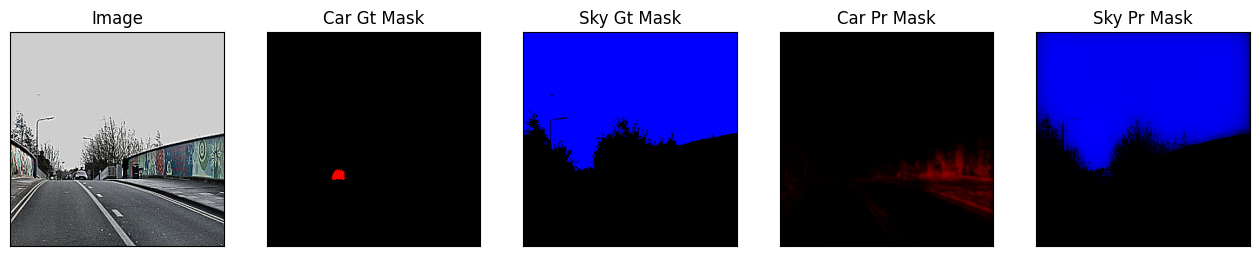

In [38]:
n = 1
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
model_dir = 'models'
model_path = model_dir + '/20241105_225601_camseg_unet.pth'

model = UNet(in_channels=3, num_classes=len(CLASSES)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

for i in ids:
    # Get image and ground truth mask from the dataset
    image, gt_mask = test_dataset[i]
    
    # Add batch dimension and convert to torch.Tensor
    image = torch.unsqueeze(image, dim=0).to(device)
    
    # Pass the image through the model to get the predicted mask
    pr_mask = model(image)
    pr_mask = torch.sigmoid(pr_mask)  # Apply sigmoid if not using softmax for binary mask
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()  # Convert to numpy for visualization

    # print("Ground truth mask shape: ", gt_mask.shape)
    print("Predicted mask shape: ", pr_mask.shape)
    print("Predicted mask: ", pr_mask)

    # Prepare colored ground truth and predicted masks
    gt_masks_colored = {f"{cls}_gt_mask": colorize_mask(gt_mask[c].cpu().numpy(), COLORS[cls]) for c, cls in enumerate(CLASSES)}
    pr_masks_colored = {f"{cls}_pr_mask": colorize_mask(pr_mask[c], COLORS[cls]) for c, cls in enumerate(CLASSES)}

    # Visualize the results
    visualize(
        image=denormalize(image.squeeze().cpu().numpy()),
        **gt_masks_colored,
        **pr_masks_colored
    )